In [5]:
from tensorflow.python.client import device_lib
for d in device_lib.list_local_devices():
   print(d.name, d.physical_device_desc)

/device:CPU:0 


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, InputLayer
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import nasnet, resnet50, densenet
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
%matplotlib inline

In [7]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_gen = train_datagen.flow_from_directory(
        'flowers/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='b',
        shuffle=True)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'flowers/train'

In [ ]:
val_gen = val_datagen.flow_from_directory(
        'flowers/valid',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

In [8]:
test_gen = test_datagen.flow_from_directory(
        'flowers/test',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

Found 819 images belonging to 102 classes.


In [9]:
batch = train_gen.next()  # this will read in 32 images from the train directory
batch[0][0]               # this is one 150,150,3 color photo
batch[1][0]               # this is the one-hot encoded label for this photo
plt.imshow(batch[0][1])
plt.show()


NameError: name 'train_gen' is not defined

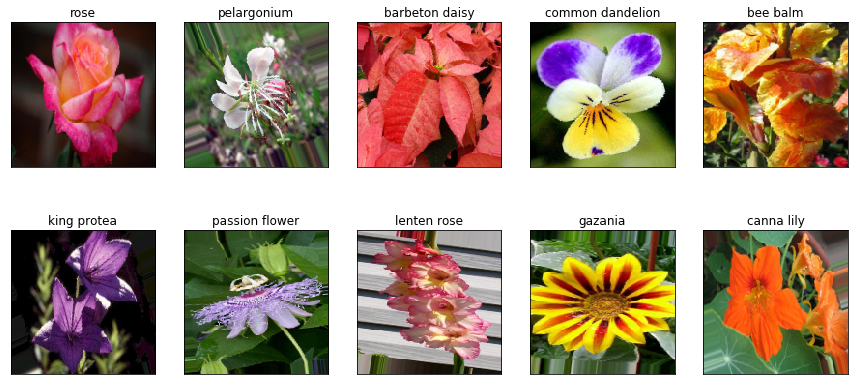

In [40]:
fig = plt.figure(figsize=(15,7))

for i in range(1,11):
    plt.subplot(2, 5, i)
    img = batch[0][i].squeeze()
    label_ind = list(batch[1][i]).index(1)
    plt.title(data[label_ind])
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [49]:
input_shape = (150, 150, 3)

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=5, padding='valid', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=5, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=5, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(102, activation='softmax'))

opt = optimizers.Nadam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 146, 146, 32)      2432      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 69, 69, 64)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 128)       204928    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 28800)            

In [50]:
train_batches = int(train_gen.samples / train_gen.batch_size) * 2
val_batches = int(val_gen.samples / val_gen.batch_size)

history = model.fit_generator(
        generator=train_gen,
        validation_data=val_gen,
        verbose=1,
        epochs=2,
        steps_per_epoch=train_batches,
        validation_steps=val_batches
)

Epoch 1/2
408/408 [==============================] - 767s 2s/step - loss: 3.6017 - categorical_accuracy: 0.1478 - val_loss: 2.7829 - val_categorical_accuracy: 0.2900
Epoch 2/2
408/408 [==============================] - 918s 2s/step - loss: 2.4429 - categorical_accuracy: 0.3631 - val_loss: 2.3893 - val_categorical_accuracy: 0.3862


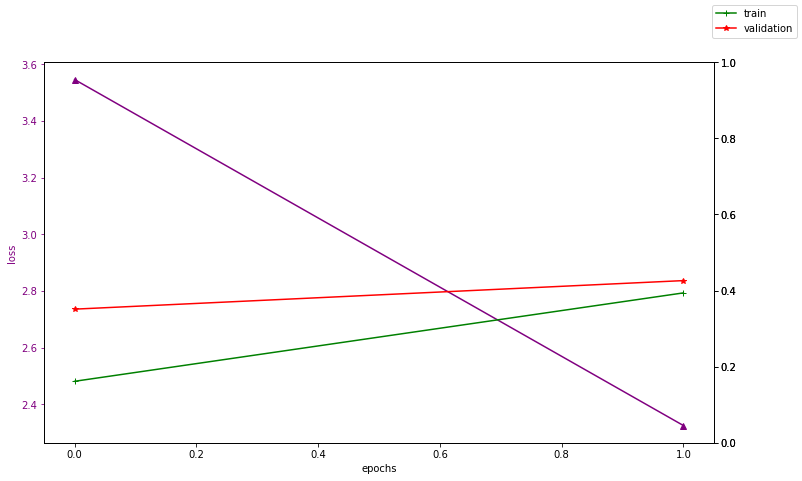

In [47]:
fig, ax1 = plt.subplots(1,1,figsize=(12,7))
ax1.plot(history.epoch, history.history['loss'], marker='^', color='purple')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
plt.plot(history.epoch, history.history['categorical_accuracy'], marker='+', color='green', label='train')
ax2.set_ylim(0,1)

ax3 = ax1.twinx()
plt.plot(history.epoch, history.history['val_categorical_accuracy'], marker='*', color='red', label='validation')
ax3.set_ylim(0,1)

fig.legend();

In [48]:
model.evaluate_generator(test_gen)

[2.4190689646280727, 0.4090354]